## Notebook for section 4.4: *Do relative representation similarities remain consistent across different datasets?*
This notebook creates the figures for the section 4.4. It plots the similarity values of all model pairs for three dataset pairs (upper row) and with colored training objectives (lower row).

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import spearmanr, pearsonr

from constants import (
    exclude_models,
    exclude_models_w_mae,
    cat_name_mapping,
    model_config_file,
    fontsizes,
    fontsizes_cols,
    model_cat_mapping,
    BASE_PATH_RESULTS,
    ds_list_sim_file
)
from helper import load_model_configs_and_allowed_models, save_or_show, pp_storing_path, load_all_datasetnames_n_info

#### Global variables

In [14]:
# Get list of all datasets
ds_list, ds_info = load_all_datasetnames_n_info(ds_list_sim_file, verbose=False)

# Get subset of datasets
ds_lists = dict(
    ds_row_1_v2=['imagenet-subset-10k', 'wds_vtab_flowers', 'wds_vtab_pcam'],
)
curr_ds_list = ds_lists['ds_row_1_v2']

# Experiment configuration
suffix = ''  # '', '_wo_mae'

# Version
version = 'arxiv'
curr_fontsizes = fontsizes if version == 'arxiv' else {k: v + 1 for k, v in fontsizes_cols.items()}

# Path to all similarities
sim_data_path = BASE_PATH_RESULTS / 'aggregated/model_sims/all_metric_ds_model_pair_similarity.csv'
assert sim_data_path.exists(), f"Path does not exist: {sim_data_path}. Aggregated similarity data not found, please run aggregate_similarities_across_datasets.ipynb before."

# Path to store plots
SAVE = False
storing_path = pp_storing_path(BASE_PATH_RESULTS / 'plots' / 'final' / version / 'sec_4_4_sim_con_scatter', SAVE)


#### Load model configurations and similarities

In [15]:
# Load model configurations and allowed models
curr_excl_models = exclude_models_w_mae if 'mae' in suffix else exclude_models

model_configs, allowed_models = load_model_configs_and_allowed_models(
    path=model_config_file,
    exclude_models=curr_excl_models,
    exclude_alignment=True,
)

Nr. models original=64


In [16]:
# Load all similarities
all_similarities = pd.read_csv(sim_data_path)
all_similarities.columns = ['Similarity metric', 'DS', 'Model 1', 'Model 2', 'Similarity value', 'Training objective',
                            'Architecture', 'Training data', 'Model size']
print(all_similarities.shape)
# filter out models that are not in the model_configs
all_similarities = all_similarities[
    all_similarities['Model 1'].isin(allowed_models) & all_similarities['Model 2'].isin(allowed_models)]
print(all_similarities.shape)

(100800, 9)
(100800, 9)


In [17]:
# Convert string to tuple
model_cats = list(model_cat_mapping.values())
for cat in model_cats:
    all_similarities.loc[:, cat] = all_similarities.loc[:, cat].apply(eval)
    all_similarities.loc[:, cat] = all_similarities.loc[:, cat].apply(
        lambda x: tuple(sorted([cat_name_mapping[x[0]], cat_name_mapping[x[1]]])))

In [18]:
## Filter bad datasets
model_similarities = all_similarities[all_similarities['DS'].isin(curr_ds_list)].copy().reset_index(drop=True)

#### Plot the similarity values of all model pairs for three dataset pairs (upper row) and with colored training objectives (lower row)

In [27]:
def get_ds_subsets(ds1, ds2, df, cat_col):
    def process_ds(ds):
        ds_data = df[df['DS'] == ds].copy().sort_values(['Model 1', 'Model 2']).reset_index(drop=True)
        ds_data.loc[:, cat_col] = ds_data.loc[:, cat_col].astype(str)
        return ds_data

    return process_ds(ds1), process_ds(ds2)


def plot_reg(ax, x, y, color_line, color_scatter, marker='o'):
    sns.regplot(
        x=x, y=y,
        # color=color,
        line_kws=dict(alpha=1, ls='--', lw=3, color=color_line),
        scatter_kws=dict(alpha=0.8, s=7, color=color_scatter),
        ci=None, ax=ax,
        marker=marker
    )
    ax.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))
    ax.tick_params('both', labelsize=curr_fontsizes['ticks'])


def set_ylabel(ax, j, ds2, name, color):
    if j == 0 and version == 'arxiv':
        ax.text(-0.2, 0.5, name, fontsize=curr_fontsizes['title'],
                transform=ax.transAxes, va='center', ha='right', rotation=90, color=color)
    ax.set_ylabel(get_ds_name(ds2), fontsize=curr_fontsizes['title'])


def get_ds_name(ds):
    curr_ds_info = ds_info.loc[ds]
    # return f"{curr_ds_info['name']} ({curr_ds_info['domain']})"
    return f"{curr_ds_info['name']}"


def compute_r(x, y, corr_type):
    corr_funcs = {'spearmanr': spearmanr, 'pearsonr': pearsonr}
    if corr_type not in corr_funcs:
        raise ValueError("Unknown correlation computation type")
    return corr_funcs[corr_type](x, y)[0]


def plot_all_pairs(ax, ds1_data, ds2_data, color_all, corr_type, frameon, box_anchor):
    plot_reg(ax, ds1_data['Similarity value'], ds2_data['Similarity value'], 'dimgray', color_all)
    r_val_combi = compute_r(ds1_data['Similarity value'], ds2_data['Similarity value'], corr_type)
    ax.legend(handles=[Line2D([0], [0], color=color_all, marker='o', linestyle='None', markersize=7, alpha=1)],
              labels=[f"r coeff.: {r_val_combi:.2f}"],
              fontsize=curr_fontsizes['label'],
              framealpha=0.5,
              frameon=frameon, title='', loc='lower right',
              markerfirst=False,
              handletextpad=0.01,
              borderpad=0, bbox_to_anchor=box_anchor,
              edgecolor='white')
    ax.set_xlabel("")


def plot_within_category(ax, ds1_data, ds2_data, cat_col, color_all, cat_colors, corr_type, frameon, box_anchor):
    marker_list = ['o', 's', '^']

    within_cat = ds1_data[cat_col].apply(eval).apply(lambda x: x[0] == x[1])
    ax.scatter(x=ds1_data.loc[~within_cat, 'Similarity value'], y=ds2_data.loc[~within_cat, 'Similarity value'],
               c=color_all, alpha=0.4, s=5)

    ds1_data, ds2_data = ds1_data.loc[within_cat, :], ds2_data.loc[within_cat, :]

    handles, labels = [], []
    for i, cat_pair in enumerate(ds1_data[cat_col].unique()):
        ds1_sub = ds1_data[ds1_data[cat_col] == cat_pair]
        ds2_sub = ds2_data[ds2_data[cat_col] == cat_pair]
        curr_color = cat_colors[eval(cat_pair)[0]]

        plot_reg(ax, ds1_sub['Similarity value'], ds2_sub['Similarity value'], curr_color, curr_color, marker_list[i])
        r_val_combi = compute_r(ds1_sub['Similarity value'], ds2_sub['Similarity value'], corr_type)
        handles.append(
            Line2D([0], [0], color=curr_color, marker=marker_list[i], linestyle='None', markersize=7, alpha=1))
        labels.append(f"r {eval(cat_pair)[0]}: {r_val_combi:.2f}")

    ax.legend(handles=handles, labels=labels, fontsize=curr_fontsizes['label'], framealpha=0.75,
              frameon=frameon, title='', loc='lower right', edgecolor='white', handletextpad=0.01, alignment='right',
              markerfirst=False, reverse=True, borderpad=0, bbox_to_anchor=box_anchor)


def main_plot(curr_ds_list, tmp, cat_col, color_all, cat_colors, corr_type, frameon, box_anchor):
    combs = list(combinations(curr_ds_list, 2))
    n, m = 2, len(combs)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5 * m, 4 * n), sharex=True, sharey=True)

    ticks = np.linspace(0, 1, 3)
    tick_labels = [f'{x:.1f}' for x in ticks]

    for j, (ds1, ds2) in enumerate(combs):
        ds1_data, ds2_data = get_ds_subsets(ds1, ds2, tmp, cat_col)

        # Upper row: all pairs
        plot_all_pairs(axs[0, j], ds1_data, ds2_data, color_all, corr_type, frameon, box_anchor)
        set_ylabel(axs[0, j], j, ds2, "All model pairs", 'black')

        # Lower row: within category
        plot_within_category(axs[1, j], ds1_data, ds2_data, cat_col, color_all, cat_colors, corr_type, frameon,
                             box_anchor)
        axs[1, j].set_xlabel(get_ds_name(ds1), fontsize=curr_fontsizes['title'])
        set_ylabel(axs[1, j], j, ds2, "Within training objective", 'black')

        for ax in [axs[0, j], axs[1, j]]:
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
            ax.set_xticklabels(tick_labels, fontsize=curr_fontsizes['ticks'])
            ax.set_yticklabels(tick_labels, fontsize=curr_fontsizes['ticks'])

    fig.subplots_adjust(hspace=0.1, wspace=0.15)
    return fig

CKA RBF 0.4 pearsonr


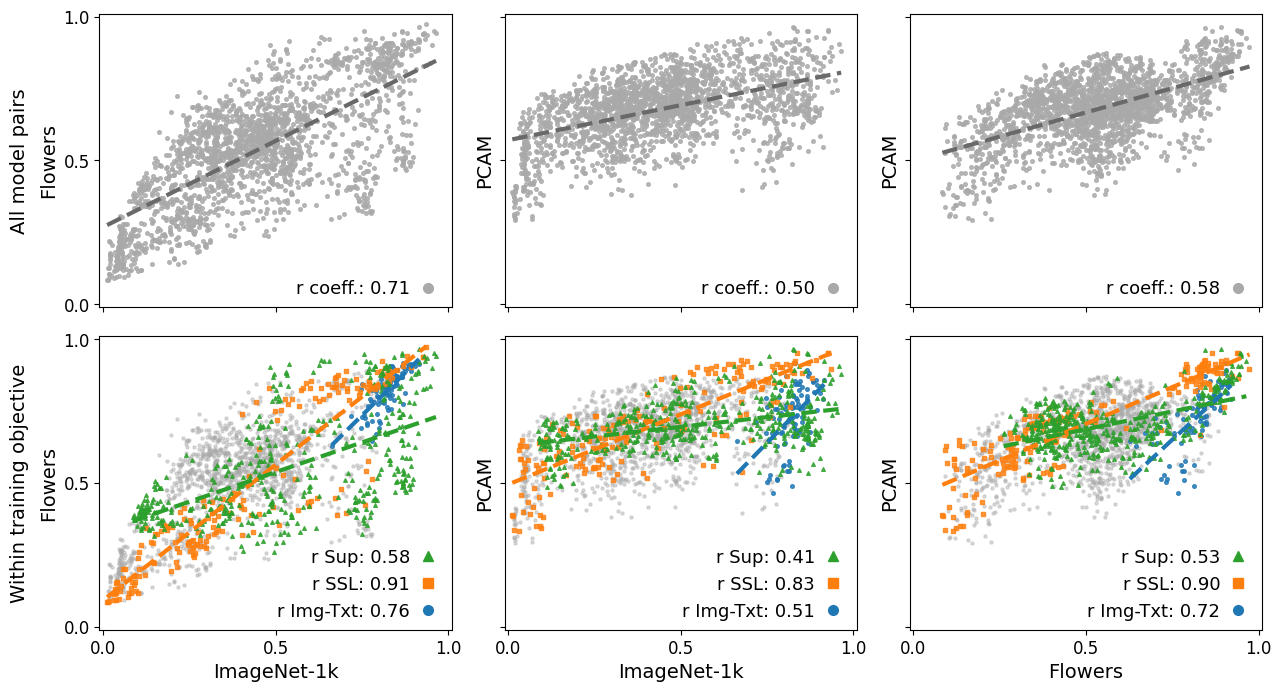

CKA RBF 0.4 spearmanr


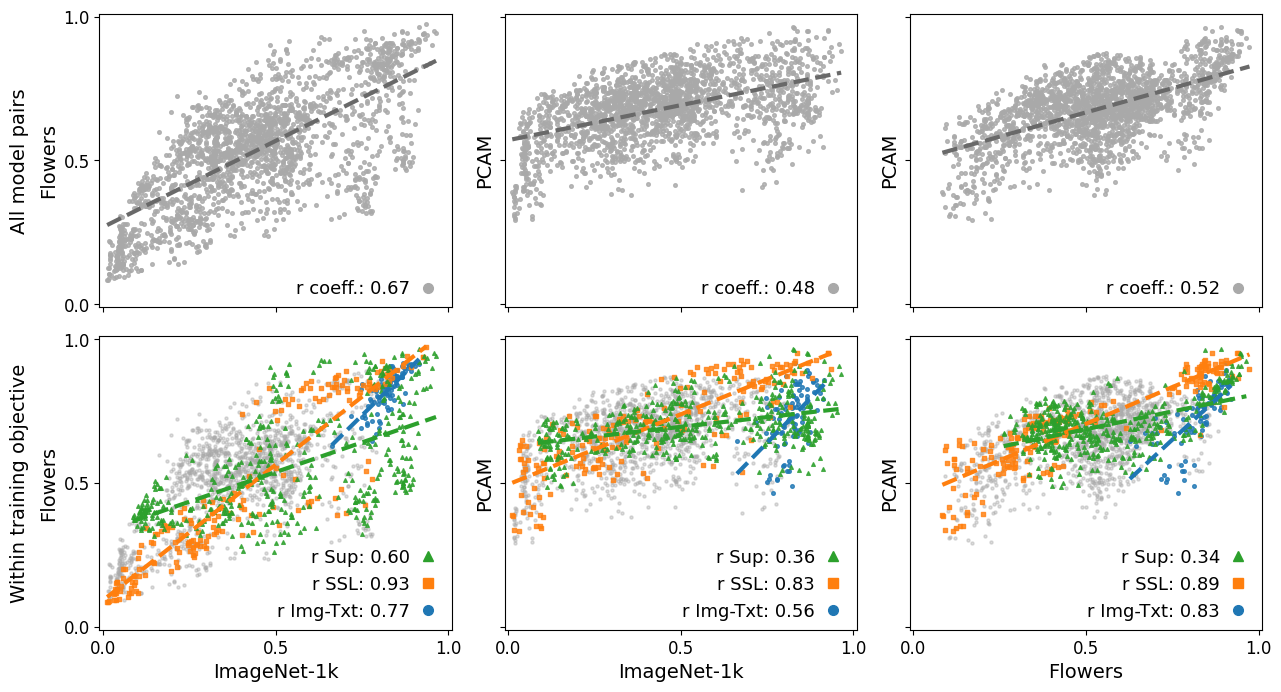

CKA linear pearsonr


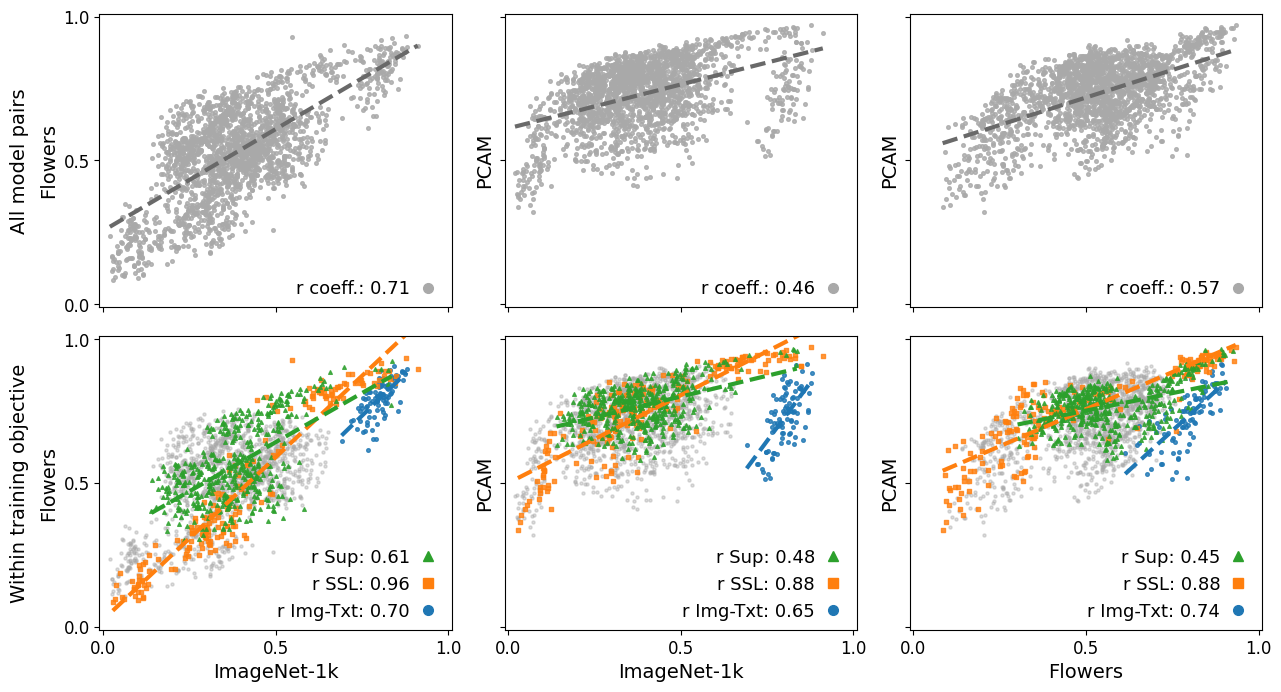

CKA linear spearmanr


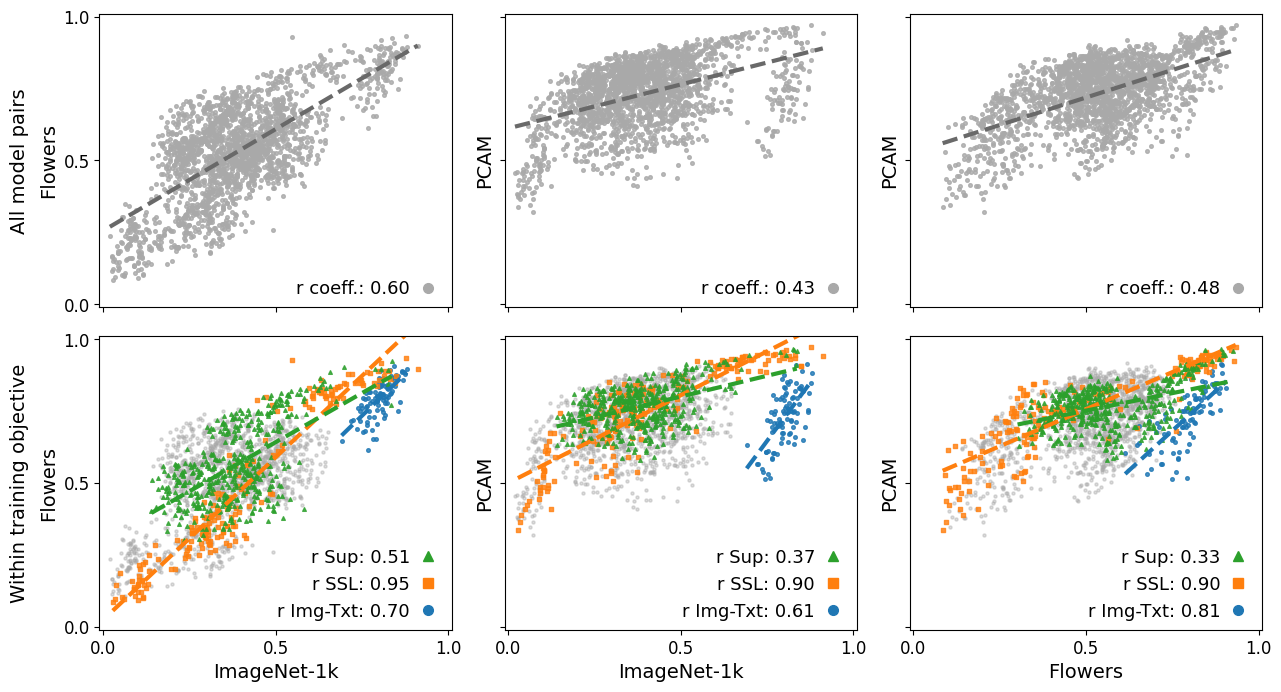

In [28]:
import numpy as np

cat_col = 'Training objective'
color_all = 'darkgrey'
frameon = False
box_anchor = (1.01, 0) if version == 'arxiv' else (1.05, 0)

for sim_metric, data in model_similarities.groupby('Similarity metric'):
    for corr_type in ['pearsonr', 'spearmanr']:
        print(sim_metric, corr_type)
        cat_ois = sorted(list(set([element for tup in data[cat_col].unique() for element in tup])))
        cat_colors = {cat_oi: color for cat_oi, color in zip(cat_ois, sns.color_palette('tab10', len(cat_ois)))}
        fig = main_plot(curr_ds_list, data, cat_col, color_all, cat_colors, corr_type=corr_type, frameon=frameon,
                        box_anchor=box_anchor)

        curr_sim = sim_metric.lower().replace(' ', '_')
        save_or_show(fig, storing_path / f'{cat_col}_{corr_type}_{curr_sim}{suffix}.pdf', SAVE)